In [1]:
# Load in packages and data

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ReduceLROnPlateau

from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from tensorflow.keras.backend import clear_session


from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

from functions import get_eff_faker_err, train_test_split_by_part, get_eff_faker_vs_feat

import gc

In [15]:
# Take in .root into arrays
arrays = (uproot.open("TTbar_PU200_D49_prompt.root")["L1TrackNtuple/eventTree"]
                .arrays("*", namedecode="utf-8"))

In [ ]:
# Create train and test samples

In [16]:
# Select features from data and put in proper format
# 'trk_fake' is the track quality variable, truth data

features = ['trk_pt','trk_eta','trk_phi','trk_z0','trk_chi2rphi','trk_chi2rz','trk_bendchi2','trk_bendchi2']
X = np.empty((len(arrays[features[0]].flatten()),len(features)))
for i in range(len(features)):
    X[:,i] = arrays[features[i]].flatten()

y = arrays['trk_fake'].flatten()
y[y==2] = 1

# Grab pdgid for certain studies
pdgid = arrays['trk_matchtp_pdgid'].flatten()


In [17]:
# Get rid of any nan instances for training purposes (doesn't converge)
find_nan = np.argwhere(np.isnan(X))
X = np.delete(X, find_nan[:,0], 0)
y = np.delete(y, find_nan[:,0])
pdgid = np.delete(pdgid, find_nan[:,0])

In [18]:
# Create train and test sets with 2500 of each mu, elec, had, fake in train, rest in test
X_train, y_train, pdgid_train, X_test, y_test, pdgid_test = train_test_split_by_part(X,y,pdgid,2500,2500,2500,2500)

In [ ]:
# Configure neural network (NN)

In [30]:
clear_session()

In [31]:
# This creates a Quantized NN with 2 hidden layers and one output layer
# The first hidden layer has 128 nodes, and the second has 64 nodes
# The output is a single node with a value between 0 and 1
# More information of QKeras here: https://github.com/google/qkeras
# Quanitized bits are of the form <16,8> where 16 is total bits, 8 is integer bits
# L1 Regularization is recommended in order to keep weights close to 0 while training

bits = 16
ints = 8
l1Reg = 0.001

Inputs = Input(shape=X_train.shape[1:])

x = QDense(128,activation=None, kernel_initializer='lecun_uniform',
              kernel_regularizer = l1(l1Reg),
              bias_regularizer = l1(l1Reg),
              kernel_quantizer=quantized_bits(bits,ints,alpha=1),
              bias_quantizer=quantized_bits(bits,ints,alpha=1),
              name="Dense_Layer_1")(Inputs)

  
x = QActivation(activation=quantized_relu(bits,ints),name="Relu_Layer_1")(x)
    
x = QDense(64,activation=None, kernel_initializer='lecun_uniform',
              kernel_regularizer = l1(l1Reg),
              bias_regularizer = l1(l1Reg),
              kernel_quantizer=quantized_bits(bits,ints,alpha=1), 
              bias_quantizer=quantized_bits(bits,ints,alpha=1),
              name="Dense_Layer_2")(x)

   
x= QActivation(activation=quantized_relu(bits),name="Relu_Layer_2")(x)
    
x = QDense(1,activation=None, kernel_initializer='lecun_uniform',
              kernel_regularizer = l1(l1Reg),
              bias_regularizer = l1(l1Reg),
              kernel_quantizer=quantized_bits(bits,ints,alpha=1),
              bias_quantizer=quantized_bits(bits,ints,alpha=1),
              name="Dense_Layer_4")(x)

   
predictions = Activation(activation='sigmoid',name="Sigmoid_Output_Layer")(x)
   
clf_QNN = Model(inputs=Inputs, outputs=predictions)

    

In [ ]:
# Configure sparse training to a total 75% pruning beginning mid way through the training 

In [32]:
epochs = 100
batch_size = 64
total_prune = 0.75
total_steps = epochs*len(X_train)/batch_size
pruning_params = {"pruning_schedule" : pruning_schedule.PolynomialDecay(
    0.0, 0.75, int(total_steps/2), int(total_steps), power=3, frequency=100
)}
clf_QNN = prune.prune_low_magnitude(clf_QNN, **pruning_params)

In [33]:
train = True
if train:
    adam = Adam(lr=0.0001)
    clf_QNN.compile(optimizer=adam, loss=['binary_crossentropy'], metrics=['accuracy'])
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, 
                                mode='min', verbose=1, min_delta=0.001,
                                 cooldown=2, min_lr=0.000000001)]
    callbacks.append(pruning_callbacks.UpdatePruningStep())
    clf_QNN.fit(X_train, y_train, batch_size=batch_size,
              epochs=epochs, validation_split=0.1, shuffle=True,
              callbacks = callbacks)

    clf_QNN = strip_pruning(clf_QNN)
    clf_QNN.save('QNN.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    clf_QNN = load_model('QNN.h5', custom_objects=co)

Epoch 1/100
141/141 [==============================] - 7s 47ms/step - loss: 1.5914 - accuracy: 0.5947 - val_loss: 1.4516 - val_accuracy: 0.7340 - lr: 1.0000e-04
Epoch 2/100
141/141 [==============================] - 4s 31ms/step - loss: 1.3888 - accuracy: 0.7541 - val_loss: 1.3489 - val_accuracy: 0.7510 - lr: 1.0000e-04
Epoch 3/100
141/141 [==============================] - 4s 30ms/step - loss: 1.2997 - accuracy: 0.7678 - val_loss: 1.2760 - val_accuracy: 0.7630 - lr: 1.0000e-04
Epoch 4/100
141/141 [==============================] - 4s 31ms/step - loss: 1.2305 - accuracy: 0.7828 - val_loss: 1.2120 - val_accuracy: 0.7740 - lr: 1.0000e-04
Epoch 5/100
141/141 [==============================] - 5s 33ms/step - loss: 1.1717 - accuracy: 0.7868 - val_loss: 1.1579 - val_accuracy: 0.7960 - lr: 1.0000e-04
Epoch 6/100
141/141 [==============================] - 4s 28ms/step - loss: 1.1211 - accuracy: 0.7948 - val_loss: 1.1083 - val_accuracy: 0.7980 - lr: 1.0000e-04
Epoch 7/100
141/141 [=============

In [ ]:
# Check NN performance

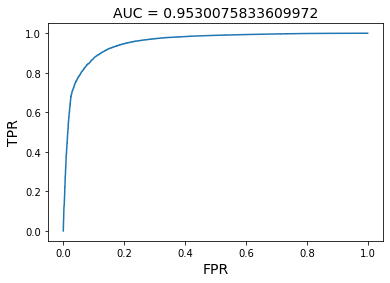

In [34]:
# Create roc curve with AUC (area under curve) value
y_pred = clf_QNN.predict(X_test)[:,0]
fpr, tpr, dt = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr,tpr)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.title('AUC = '+str(auc),fontsize=14)
plt.show()

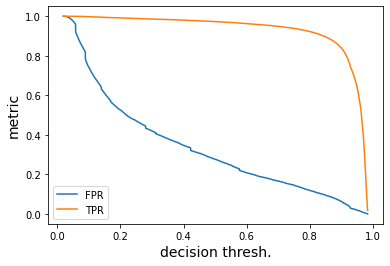

In [34]:
# Plot TPR and FPR vs decision threshold (dt)
plt.plot(dt[1:],fpr[1:],label='FPR')
plt.plot(dt[1:],tpr[1:],label='TPR')
plt.xlabel('decision thresh.',fontsize=14)
plt.ylabel('metric',fontsize=14)
plt.legend(loc='best')
plt.show()

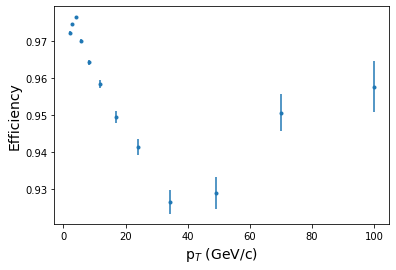

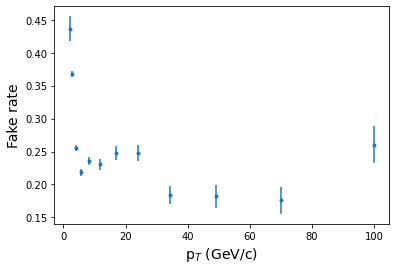

In [37]:
# Create efficiency/fake rate vs. pt
pt, eff, faker, err_eff, err_faker = get_eff_faker_vs_feat('pt',features,X_test,y_test,clf_QNN)

plt.errorbar(pt,eff,yerr=err_eff,linestyle='None',fmt='.')
plt.xlabel('p$_{T}$ (GeV/c)',fontsize=14)
plt.ylabel('Efficiency',fontsize=14)
plt.show()

plt.errorbar(pt,faker,yerr=err_faker,linestyle='None',fmt='.')
plt.xlabel('p$_{T}$ (GeV/c)',fontsize=14)
plt.ylabel('Fake rate',fontsize=14)
plt.show()

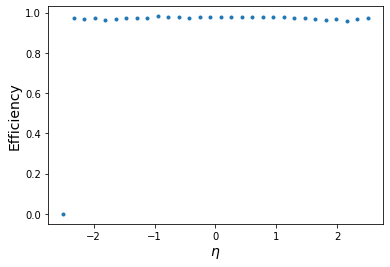

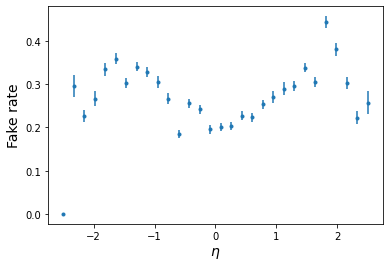

In [39]:
# Create efficiency/fake rate vs. eta
pt, eff, faker, err_eff, err_faker = get_eff_faker_vs_feat('eta',features,X_test,y_test,clf_QNN)

plt.errorbar(pt,eff,yerr=err_eff,linestyle='None',fmt='.')
plt.xlabel('$\eta$',fontsize=14)
plt.ylabel('Efficiency',fontsize=14)
plt.show()

plt.errorbar(pt,faker,yerr=err_faker,linestyle='None',fmt='.')
plt.xlabel('$\eta$',fontsize=14)
plt.ylabel('Fake rate',fontsize=14)
plt.show()